# **Reading Score model**

## Objectives

- Train and evaluate a model for predicting a student's reading score

## Inputs

- outputs/datasets/filtered/reading-score-dataset.csv
- outputs/datasets/split/math/reading-test-score.csv
- outputs/datasets/split/reading/reading-train-score.csv
- outputs/datasets/split/reading/reading-test-vars.csv
- outputs/datasets/split/reading/reading-train-vars.csv

## Outputs

- A pipeline to predict a student's reading score

## Additional comments

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [1]:
import os
current_directory = os.getcwd()
current_directory


'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [2]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [3]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

Import packages:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Reading Score pipeline

The reading_score variable is a continuous numerical variable, so we would normally construct and evaluate a regression model. However, with the pipeline to predict math_score, we saw that a regression model showed poor predictive performance, leading to conversion to a classification task, which showed far better performance. Therefore, we are faced with something of a dilemma - we can repeat the workflow we used in predicting math_score - regression followed by classification, or we can skip construction and evaluation of a regression model and begin with a classification model, on the basis that a regression would very likely show poor performance. 

If we look back at the correlation study notebook, we note that the math_score variable had the highest correlation scores and predictive power scores, and regression model performance was still poor. Therefore, beginning with a classification model seems like the best approach. As in the math_score classification notebook, we will explore 2, 3 and 3 bin approaches.

First, we load the necessary dataset:

In [5]:
df_reading = pd.read_csv('outputs/datasets/filtered/reading-score-dataset.csv')
df_reading

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,reading_score
0,male,group A,high school,standard,completed,67
1,female,group D,some high school,free/reduced,none,59
2,male,group E,some college,free/reduced,none,60
3,male,group B,high school,standard,none,78
4,male,group E,associate's degree,standard,completed,73
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,70
996,male,group D,associate's degree,free/reduced,completed,91
997,female,group C,some high school,free/reduced,none,35
998,female,group C,some college,standard,none,74


Now must define the various objects that we will use to perform the analyses:

In [6]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

Now the pipeline. Most pipelines use a StandardScaler step, however we don't need one here, because all of our feature variables are encoded categorical variables, and a StandardScaler only has use when we have continuous numerical variables.

In [7]:
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['gender', 'ethnicity', 'parental_education', 'lunch_program', 'test_preparation_course'] ) ),      

      ("feature_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

And now the algorithms and default hyperparameters that we will use. We will use different dictionaries in each section to hold the selected model and hyperparameters that we want to test, depending on what algorithm performs best. The SGDClassifier algorithm was used, but is currently commented out due to the difficulties encountered.

In [8]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    # "SGDClassifier": SGDClassifier(random_state=0),
}

parameters_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
    # "SGDClassifier": {}
}

And finally the code for generating a classification report and confusion matrix:

In [9]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(reading_train_vars, reading_train_score, reading_test_vars, reading_test_score, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(reading_train_vars, reading_train_score, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(reading_test_vars, reading_test_score, pipeline, label_map)

## 2 bin approach

We can now sort the reading_score variable of df_reading into 2 bins.

* The classes represent the following ranges: 
{'reading_score': [-inf, 70.0, inf]} 



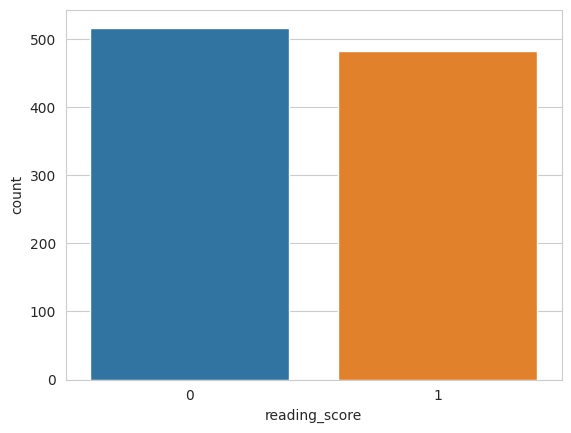

In [10]:
disc_efd_2 = EqualFrequencyDiscretiser(q=2, variables=['reading_score'])
df_reading_clf_efd_2 = disc_efd_2.fit_transform(df_reading)

print(f"* The classes represent the following ranges: \n{disc_efd_2.binner_dict_} \n")
sns.countplot(data=df_reading_clf_efd_2, x='reading_score')
plt.show()

In [11]:
df_reading_clf_efd_2

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,reading_score
0,male,group A,high school,standard,completed,0
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,1
4,male,group E,associate's degree,standard,completed,1
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,0
996,male,group D,associate's degree,free/reduced,completed,1
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,1


In [12]:
reading_train_vars_2, reading_test_vars_2, reading_train_score_2, reading_test_score_2 = train_test_split(
    df_reading_clf_efd_2.drop(['reading_score'], axis=1),
    df_reading_clf_efd_2['reading_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", reading_train_vars_2.shape, reading_train_score_2.shape, "\n* Test set:",  reading_test_vars_2.shape, reading_test_score_2.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


We can now run our algorithm search:

In [13]:
model_search_2 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_2.fit(reading_train_vars_2, reading_train_score_2, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Inde


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [14]:
efd_2_model_grid_search_summary, efd_2_model_grid_search_pipelines = model_search_2.score_summary(sort_by='mean_score')
efd_2_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
0,XGBClassifier,0.426829,0.707317,0.890244,0.21444
1,DecisionTreeClassifier,0.54878,0.658537,0.792683,0.085887
4,ExtraTreesClassifier,0.54878,0.658537,0.792683,0.085887
2,RandomForestClassifier,0.54878,0.656098,0.780488,0.082134
5,AdaBoostClassifier,0.5,0.597561,0.743902,0.08126
3,GradientBoostingClassifier,0.426829,0.558537,0.707317,0.11161


Interesting - the XGBClassifier performs best by a significant margin. We can now optimise the hyperparameters. First, we define the dictionaries holding the chosen model and the hyperparameters:

In [15]:
models_2 = {
    "XGBClassifier": XGBClassifier(random_state=0)
}
 
parameters_2 = {
    "XGBClassifier":{
                    'model__n_estimators': [30, 80, 200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01, 0.1, 0.001],
                    'model__gamma': [0, 0.1],
                    }
}

And now we call the hyperparameter optimisation class:

In [16]:
parameters_search_2 = HyperparameterOptimizationSearch(models=models_2, parameters=parameters_2)
parameters_search_2.fit(reading_train_vars_2, reading_train_score_2, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Now we can inspect the results:

In [17]:
efd_2_parameters_grid_search_summary, efd_2_parameters_grid_search_pipelines = parameters_search_2.score_summary(sort_by='mean_score')
efd_2_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__gamma,model__learning_rate,model__max_depth,model__n_estimators
0,XGBClassifier,0.426829,0.707317,0.890244,0.21444,0,0.01,None,30
40,XGBClassifier,0.426829,0.707317,0.890244,0.21444,0.1,0.1,3,80
29,XGBClassifier,0.426829,0.707317,0.890244,0.21444,0.1,0.01,None,200
30,XGBClassifier,0.426829,0.707317,0.890244,0.21444,0.1,0.01,3,30
31,XGBClassifier,0.426829,0.707317,0.890244,0.21444,0.1,0.01,3,80


It appears that we cannot optimise the hyperparameters of the XGBClassifier. We will continue, saving the best model and hyperparameters in memory, and then assessing feature importance and generating a classification report and confusion matrix:

In [18]:
reading_efd_2_best_model = efd_2_parameters_grid_search_summary.iloc[0,0]
reading_efd_2_best_model

'XGBClassifier'

In [19]:
reading_efd_2_best_parameters = efd_2_parameters_grid_search_pipelines[reading_efd_2_best_model].best_params_
reading_efd_2_best_parameters

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': None,
 'model__n_estimators': 30}

In [20]:
efd_2_pipeline_clf = efd_2_parameters_grid_search_pipelines[reading_efd_2_best_model].best_estimator_
efd_2_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=N...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
           

We can now assess feature importances:

* These are the 2 most important features in descending order. The model was trained on them: 
['lunch_program', 'test_preparation_course']


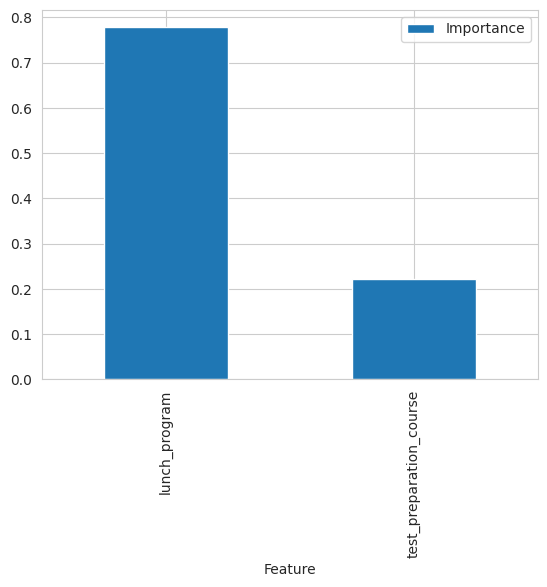

In [21]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(efd_2_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(reading_train_vars_2)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_2 = columns_after_data_cleaning_feat_eng[efd_2_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_2 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[efd_2_pipeline_clf['feature_selection'].get_support()],
          'Importance': efd_2_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

reading_efd_2_best_features = df_feature_importance_2['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_2)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_2}")

df_feature_importance_2.plot(kind='bar',x='Feature',y='Importance')
plt.show()

This is an interesting result, and very in line with our findings from the data analysis. The lunch_program and test_preparation_course variables have been identified as the most important feature variables.

In [22]:
disc_efd_2.binner_dict_['reading_score']

[-inf, 70.0, inf]

In [23]:
reading_efd_2_label_map = ['<70.0', '>70.0']
reading_efd_2_label_map

['<70.0', '>70.0']

Now we can generate a classification report and confusion matrix:

In [24]:
clf_performance(reading_train_vars_2, reading_train_score_2, reading_test_vars_2, reading_test_score_2, efd_2_pipeline_clf, reading_efd_2_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                 Actual <70.0 Actual >70.0
Prediction <70.0          360          256
Prediction >70.0           50          134


---  Classification Report  ---
              precision    recall  f1-score   support

       <70.0       0.58      0.88      0.70       410
       >70.0       0.73      0.34      0.47       390

    accuracy                           0.62       800
   macro avg       0.66      0.61      0.58       800
weighted avg       0.65      0.62      0.59       800
 

#### Test Set ####

---  Confusion Matrix  ---
                 Actual <70.0 Actual >70.0
Prediction <70.0           91           68
Prediction >70.0           16           25


---  Classification Report  ---
              precision    recall  f1-score   support

       <70.0       0.57      0.85      0.68       107
       >70.0       0.61      0.27      0.37        93

    accuracy                           0.58       200
   macro avg       0.59      0.

Amazing - for the lowest performing ('failing') class, we see a recall score of 0.88 the train set and 0.85 on the test set. This is unfortunately balanced out by the higher-performing ('passing') class, which has a recall score of 0.34 for the train set and 0.27 for the test set.

This is most acceptable, since the business requirements state that we want to be able to reliably predict students who will fall into the lowest performing class. The poor performance on the higher-performing class is immaterial.

We will now examine the 3 bin approach.

## 3 bin approach

* The classes represent the following ranges: 
{'reading_score': [-inf, 63.0, 76.0, inf]} 



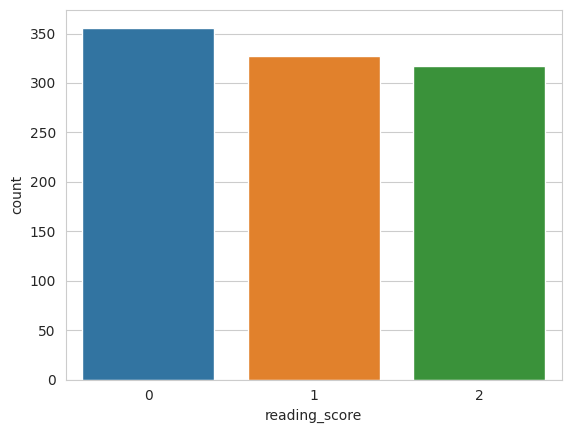

In [25]:
disc_efd_3 = EqualFrequencyDiscretiser(q=3, variables=['reading_score'])
df_reading_clf_efd_3 = disc_efd_3.fit_transform(df_reading)

print(f"* The classes represent the following ranges: \n{disc_efd_3.binner_dict_} \n")
sns.countplot(data=df_reading_clf_efd_3, x='reading_score')
plt.show()

Looks to be evenly distributed. The widths of the bins are different from those assigned to the math_score. These are:
- less than 63
- 63 to 76
- Greater than 76

We'll now inspect the discretised dataset

In [26]:
df_reading_clf_efd_3

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,reading_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,2
4,male,group E,associate's degree,standard,completed,1
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,2
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,1


Now we must split the discretised dataset:

In [27]:
reading_train_vars_3, reading_test_vars_3, reading_train_score_3, reading_test_score_3 = train_test_split(
    df_reading_clf_efd_3.drop(['reading_score'], axis=1),
    df_reading_clf_efd_3['reading_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", reading_train_vars_3.shape, reading_train_score_3.shape, "\n* Test set:",  reading_test_vars_3.shape, reading_test_score_3.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


During development, I tried the NaiveBayesClassifier, Support Vector Machine and KNeighborsClassifier algorithms but ran into problems

Now we can call the HyperparameterOptimizationSearch class

In [28]:
model_search_3 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_3.fit(reading_train_vars_3, reading_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index 


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Now we can inspect the results:

In [29]:
reading_efd_3_model_grid_search_summary, reading_efd_3_model_grid_search_pipelines = model_search_3.score_summary(sort_by='mean_score')
reading_efd_3_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
1,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995
2,RandomForestClassifier,0.482143,0.568636,0.636364,0.059995
4,ExtraTreesClassifier,0.482143,0.568636,0.636364,0.059995
5,AdaBoostClassifier,0.381818,0.492792,0.6,0.076326
0,XGBClassifier,0.290909,0.43474,0.571429,0.090359
3,GradientBoostingClassifier,0.236364,0.413442,0.527273,0.097093


As with the math_score notebook, the DecisionTreeClassifier has top place, but the RandomForestClassifer and ExtraTreesClassifier actually have identical results, and so are effectively tied for top place. Mean scores of 0.56 are not particularly impressive, but should suffice. To compensate for this reduced performance, we will take all 3 top performing algorithms forward for hyperparameter optimisation.

In [30]:
models_3 = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}
 
parameters_3 = {
    "DecisionTreeClassifier": {
                            'model__max_depth': [None, 4, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            'model__max_leaf_nodes': [None, 50],
                            },

    "RandomForestClassifier": {
                            'model__n_estimators': [100,50, 140],
                            'model__max_depth': [None,4, 15],
                            'model__min_samples_split': [2,50],
                            'model__min_samples_leaf': [1,50],
                            'model__max_leaf_nodes': [None,50],
                            },

     "ExtraTreesClassifier": {
                            'model__n_estimators': [100,50,150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1,50],
                            }
}

In [31]:
parameters_search_3 = HyperparameterOptimizationSearch(models=models_3, parameters=parameters_3)
parameters_search_3.fit(reading_train_vars_3, reading_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [32]:
reading_efd_3_parameters_grid_search_summary, reading_efd_3_parameters_grid_search_pipelines = parameters_search_3.score_summary(sort_by='mean_score')
reading_efd_3_parameters_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
43,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,None,50,50,2,50
46,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,None,50,50,50,50
94,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,15,50,50,50,50
67,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,4,50,50,2,50
91,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,15,50,50,2,50
...,...,...,...,...,...,...,...,...,...,...
124,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,15,NaN,1,50,50
125,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,15,NaN,1,50,150
101,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,None,NaN,1,50,150
100,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,None,NaN,1,50,50


Very interesting - it appears that optimising the hyperparameters has markedly improved performance, and even more interestingly, the RandomForestClassifier has performed best. In the condensed version of the dataframe above, we don't see the DecisionTreeClassifier, which suggests middling performance. For the sake of my own curiosity, we'll query the dataframe to see how well the DecisionTreeClassifier performed.

In [33]:
reading_efd_3_parameters_grid_search_summary.query('estimator == "DecisionTreeClassifier"').head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
4,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,None,50,1,2,NaN
0,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,None,None,1,2,NaN
16,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,15,None,1,2,NaN
20,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,15,50,1,2,NaN
2,DecisionTreeClassifier,0.327273,0.567857,0.75,0.179271,None,None,50,2,NaN


Interesting - it appears the DecisionTreeClassifier's performance did not improve when the hyperparameters were optimised. Therefore, we'll note the RandomForestClassifier as the best performing algorithm for the 3-bin approach.

We must now assess feature importance and generate a classification report and confusion matrix. First, we'll save the best algorithm, hyperparameters and pipeline in memory:

In [34]:
reading_efd_3_best_model = reading_efd_3_parameters_grid_search_summary.iloc[0,0]
reading_efd_3_best_model

'RandomForestClassifier'

In [35]:
reading_efd_3_best_parameters = reading_efd_3_parameters_grid_search_pipelines[reading_efd_3_best_model].best_params_
reading_efd_3_best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [36]:
reading_efd_3_pipeline_clf = reading_efd_3_parameters_grid_search_pipelines[reading_efd_3_best_model].best_estimator_
reading_efd_3_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=50,
                                        n_estimators=50, random_state=0))])

Now we can assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


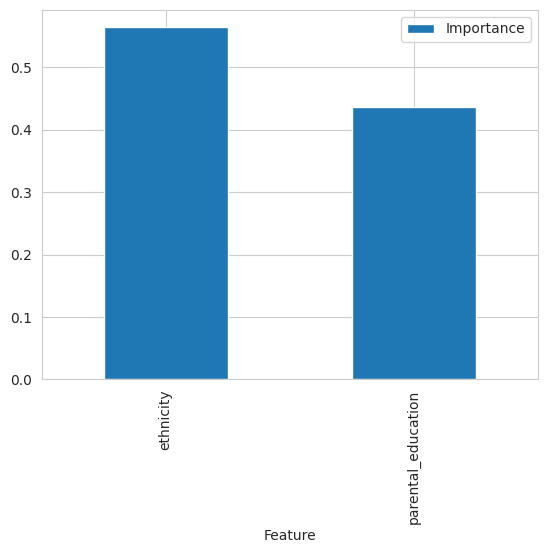

In [37]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(reading_efd_3_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(reading_train_vars_3)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_3 = columns_after_data_cleaning_feat_eng[reading_efd_3_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_3 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[reading_efd_3_pipeline_clf['feature_selection'].get_support()],
          'Importance': reading_efd_3_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

reading_efd_3_best_features = df_feature_importance_3['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_3)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_3}")

df_feature_importance_3.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - as with the math_score model training, the model has identified ethnicity and parental_education as the most important feature variables.

We'll remind ourselves of the bins:

In [38]:
disc_efd_3.binner_dict_['reading_score']

[-inf, 63.0, 76.0, inf]

Now we can define a label_map to replace the labels with more useful ones:

In [39]:
reading_efd_3_label_map = ['<63.0', '63 to 76','>76.0']
reading_efd_3_label_map

['<63.0', '63 to 76', '>76.0']

Now we can generate the classification report and confusion matrix:

In [40]:
clf_performance(reading_train_vars_3, reading_train_score_3, reading_test_vars_3, reading_test_score_3, reading_efd_3_pipeline_clf, reading_efd_3_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <63.0 Actual 63 to 76 Actual >76.0
Prediction <63.0             186             151          126
Prediction 63 to 76           31              44           36
Prediction >76.0              61              70           95


---  Classification Report  ---
              precision    recall  f1-score   support

       <63.0       0.40      0.67      0.50       278
    63 to 76       0.40      0.17      0.23       265
       >76.0       0.42      0.37      0.39       257

    accuracy                           0.41       800
   macro avg       0.41      0.40      0.38       800
weighted avg       0.41      0.41      0.38       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <63.0 Actual 63 to 76 Actual >76.0
Prediction <63.0              53              36           25
Prediction 63 to 76           12              11            9
Prediction >76.0              13              15     

Interesting - as with the math_score notebook, we see strong performance on predicting the lowest-scoring class, but weak performance when predicting the middle class and middling performance when predicting the highest-performing class. As in the math_score notebook, I think that this is acceptable, given that the intention is to identify students at risk of scoring poorly in exams. That said, this is not ideal, since we would like to be able to identify students who would score in the middle class, so that appropriate support can be offered.

## 4 bin approach

We'll now try the 4 bin approach.

* The classes represent the following ranges: 
{'reading_score': [-inf, 60.0, 70.0, 79.0, inf]} 



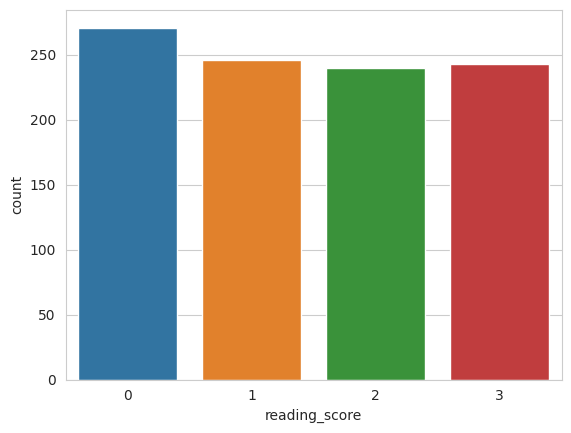

In [41]:
disc_efd_4 = EqualFrequencyDiscretiser(q=4, variables=['reading_score'])
df_reading_clf_efd_4 = disc_efd_4.fit_transform(df_reading)

print(f"* The classes represent the following ranges: \n{disc_efd_4.binner_dict_} \n")
sns.countplot(data=df_reading_clf_efd_4, x='reading_score')
plt.show()

In [42]:
df_reading_clf_efd_4

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,reading_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,2
4,male,group E,associate's degree,standard,completed,2
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,3
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,2


As before, we must re-split the dataset

In [43]:
reading_train_vars_4, reading_test_vars_4, reading_train_score_4, reading_test_score_4 = train_test_split(
    df_reading_clf_efd_4.drop(['reading_score'], axis=1),
    df_reading_clf_efd_4['reading_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", reading_train_vars_4.shape, reading_train_score_4.shape, "\n* Test set:",  reading_test_vars_4.shape, reading_test_score_4.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


Now we determine the best algorithm to use. We already have the models_quick_search and parameters_quick_search dictionaries in memory.

In [44]:
model_search_4 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_4.fit(reading_train_vars_4, reading_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index 


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [45]:
reading_efd_4_model_grid_search_summary, reading_efd_4_model_grid_search_pipelines = model_search_4.score_summary(sort_by='mean_score')
reading_efd_4_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
1,DecisionTreeClassifier,0.341463,0.45633,0.512195,0.060518
4,ExtraTreesClassifier,0.341463,0.45633,0.512195,0.060518
2,RandomForestClassifier,0.341463,0.422648,0.512195,0.068133
5,AdaBoostClassifier,0.365854,0.417538,0.487805,0.042376
3,GradientBoostingClassifier,0.170732,0.383159,0.512195,0.119521
0,XGBClassifier,0.170732,0.334262,0.47619,0.105233


As with the 3-bin approach, 2 algorithms are tied for top place - the DecisionTreeClassifier and ExtraTreeClassifier, though mean performance is significantly lower than with the 3-bin apporach. Still, optimising the hyperparameters for the 3-bin approach produced unexpectedly good results, so we will take both algorithms forward for hyperparameter optimisation.

In [46]:
models_4 = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}
 
parameters_4 = {
    "DecisionTreeClassifier": {
                            'model__max_depth': [None, 4, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            'model__max_leaf_nodes': [None, 50],
                            },

     "ExtraTreesClassifier": {
                            'model__n_estimators': [100,50,150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1,50],
                            }
}

In [47]:
parameters_search_4 = HyperparameterOptimizationSearch(models=models_4, parameters=parameters_4)
parameters_search_4.fit(reading_train_vars_4, reading_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [48]:
reading_efd_4_parameters_grid_search_summary, reading_efd_4_parameters_grid_search_pipelines = parameters_search_4.score_summary(sort_by='mean_score')
reading_efd_4_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
47,ExtraTreesClassifier,0.428571,0.534495,0.707317,0.114179,3,NaN,50,50,150
44,ExtraTreesClassifier,0.428571,0.534495,0.707317,0.114179,3,NaN,50,2,150
45,ExtraTreesClassifier,0.428571,0.519861,0.634146,0.093997,3,NaN,50,50,100
42,ExtraTreesClassifier,0.428571,0.519861,0.634146,0.093997,3,NaN,50,2,100
46,ExtraTreesClassifier,0.428571,0.514983,0.682927,0.102142,3,NaN,50,50,50


Interesting - it appears that hyperparameter optimisation has markedly improved performance, with an unusally high maximum score. However, mean score is still significantly worse than with the 3-bin approach. Therefore, we will likely proceed with the 3-bin approach

We can now assess feature importance and generate a confusion matrix and classification report

In [49]:
reading_efd_4_best_model = reading_efd_4_parameters_grid_search_summary.iloc[0,0]
reading_efd_4_best_model

'ExtraTreesClassifier'

In [50]:
reading_efd_4_best_parameters = reading_efd_4_parameters_grid_search_pipelines[reading_efd_4_best_model].best_params_
reading_efd_4_best_parameters

{'model__max_depth': 3,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

In [51]:
reading_efd_4_pipeline_clf = reading_efd_4_parameters_grid_search_pipelines[reading_efd_4_best_model].best_estimator_
reading_efd_4_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
                ('model',
                 ExtraTreesClassifier(max_depth=3, min_samples_leaf=50,
                                      n_estimators=150, random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


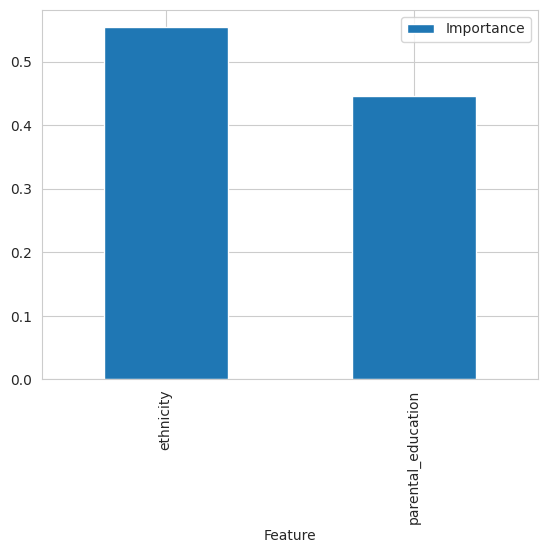

In [52]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(reading_efd_4_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(reading_train_vars_4)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_4 = columns_after_data_cleaning_feat_eng[reading_efd_4_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_4 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[reading_efd_4_pipeline_clf['feature_selection'].get_support()],
          'Importance': reading_efd_4_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

reading_efd_4_best_features = df_feature_importance_4['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_4)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_4}")

df_feature_importance_4.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - the model for the 4-bin approach was trained on the ethnicity and parental_education feature variables. The same variables were used to train the 3-bin model, but not for the 2 bin approach. This is in contrast to the math_score model training, where the 3-bin model was trained on ethnicity and parental_education but the 4-bin model was trained on the lunch_program variable.

Now we need the labels of the 4 bins

In [53]:
disc_efd_4.binner_dict_['reading_score']

[-inf, 60.0, 70.0, 79.0, inf]

In [54]:
reading_efd_4_label_map = ['<60.0', '60 to 69', '70 to 79', '>79.0']
reading_efd_4_label_map

['<60.0', '60 to 69', '70 to 79', '>79.0']

In [55]:
clf_performance(reading_train_vars_4, reading_train_score_4, reading_test_vars_4, reading_test_score_4, reading_efd_4_pipeline_clf, reading_efd_4_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <60.0 Actual 60 to 69 Actual 70 to 79 Actual >79.0
Prediction <60.0             106              75              78           41
Prediction 60 to 69           44              68              50           50
Prediction 70 to 79            0               0               0            0
Prediction >79.0              56              61              69          102


---  Classification Report  ---
              precision    recall  f1-score   support

       <60.0       0.35      0.51      0.42       206
    60 to 69       0.32      0.33      0.33       204
    70 to 79       0.00      0.00      0.00       197
       >79.0       0.35      0.53      0.42       193

    accuracy                           0.34       800
   macro avg       0.26      0.34      0.29       800
weighted avg       0.26      0.34      0.29       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <60.0 Actual 60 

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/

Interesting - as with the math_score 4-bin approach, the model is failing to predict students who fall into the 70 to 79 class. This is not good. We could overlook this if performance on the lowest scoring class was high, but it is in fact significantly worse than the 3-bin approach's performance on the lowest scoring class. 

As with the math score pipeline, we must now decide whether to proceed with the 2-bin or the 3-bin approach. The 2-bin approach uses the lunch_program and test_preparaton_course variables, whereas the 3-bin approach uses the ethnicity and parental_education variables. In the data analysis notebooks, we note that the lunch_program and test_preparation_course variables have a greater influence. The 2-bin approach also has a far higher recall score on the lowest performing class - 0.88 and 0.85 vs 0.67 and 0.68. Therefore, the obvious choice is to use the 2-bin approach.

## Final

In [ ]:
reading_efd_2_best_features

In [56]:
def PipelineOptimization(model):
  pipeline_final = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = reading_efd_2_best_features ) ),      

      ("model", model ),
       
    ])

  return pipeline_final

Because we have used different names for the 3-bin and 4-bin training and test sets, we do not need to resplit the data. We can simply recall those sets and filter them appropriately.

In [57]:
reading_train_score_final = reading_train_score_2
reading_test_score_final = reading_test_score_2

In [58]:
reading_train_vars_final = reading_train_vars_2.filter(reading_efd_2_best_features)
reading_train_vars_final.head()

,lunch_program,test_preparation_course
600,free/reduced,none
80,standard,none
158,free/reduced,none
423,standard,none
747,standard,none


In [59]:
reading_test_vars_final = reading_test_vars_2.filter(reading_efd_2_best_features)
reading_test_vars_final.head()

,lunch_program,test_preparation_course
778,free/reduced,none
334,standard,none
271,standard,none
802,standard,completed
216,standard,none


Let's just recap the best model and hyperparameters identified during the model training and evaluation

In [60]:
reading_efd_2_best_model

'XGBClassifier'

In [61]:
reading_efd_2_best_parameters

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': None,
 'model__n_estimators': 30}

We can now define these manually:

In [62]:
final_model = {
    'XGBClassifier': XGBClassifier(random_state=0)
    }

final_parameters = {'XGBClassifier': {
    'model__gamma': [0],
    'model__learning_rate': [0.01],
    'model__max_depth': [None],
    'model__n_estimators': [30]
    }}

In [63]:
search_final = HyperparameterOptimizationSearch(models=final_model, parameters=final_parameters)
search_final.fit(reading_train_vars_final, reading_train_score_final,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index 

In [64]:
grid_search_summary_reading_final, grid_search_pipelines_reading_final = search_final.score_summary(sort_by='mean_score')
grid_search_summary_reading_final

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__gamma,model__learning_rate,model__max_depth,model__n_estimators
0,XGBClassifier,0.426829,0.707317,0.890244,0.21444,0,0.01,None,30


In [65]:
final_reading_model = grid_search_summary_reading_final.iloc[0,0]
final_reading_model

'XGBClassifier'

In [66]:
pipeline_clf_reading_final = grid_search_pipelines_reading_final[final_reading_model].best_estimator_
pipeline_clf_reading_final

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['lunch_program',
                                           'test_preparation_course'])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=30,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subs

* These are the 2 most important features in descending order. The model was trained on them: 
['lunch_program', 'test_preparation_course']


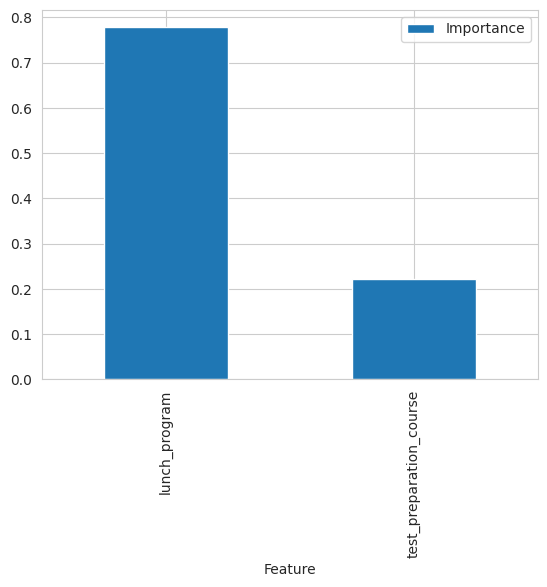

In [67]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_reading_final.steps[:data_cleaning_feat_eng_steps])
                                        .transform(reading_train_vars_final)
                                        .columns)

# create DataFrame to display feature importance
df_feature_importance_final = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf_reading_final['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features_final = df_feature_importance_final['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_final)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_final}")

df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [68]:
clf_performance(reading_train_vars_final, reading_train_score_final, reading_test_vars_final, reading_test_score_final, pipeline_clf_reading_final, reading_efd_2_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                 Actual <70.0 Actual >70.0
Prediction <70.0          360          256
Prediction >70.0           50          134


---  Classification Report  ---
              precision    recall  f1-score   support

       <70.0       0.58      0.88      0.70       410
       >70.0       0.73      0.34      0.47       390

    accuracy                           0.62       800
   macro avg       0.66      0.61      0.58       800
weighted avg       0.65      0.62      0.59       800
 

#### Test Set ####

---  Confusion Matrix  ---
                 Actual <70.0 Actual >70.0
Prediction <70.0           91           68
Prediction >70.0           16           25


---  Classification Report  ---
              precision    recall  f1-score   support

       <70.0       0.57      0.85      0.68       107
       >70.0       0.61      0.27      0.37        93

    accuracy                           0.58       200
   macro avg       0.59      0.

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Excellent - performance is unchanged, proving that the variables identified as unimportant have no bearing on the predictive ability of the pipeline.

We can now save the files

In [70]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_reading/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_reading/v1'


In [71]:
! rm outputs/ml_pipeline/predict_reading/v1/reading-train-vars.csv
reading_train_vars_final.to_csv(f'{file_path}/reading-train-vars.csv', index=False)
print(f'reading-train-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_reading/v1/reading-train-score.csv
reading_train_score_final.to_csv(f'{file_path}/reading-train-score.csv', index=False)
print(f'reading-train-score.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_reading/v1/reading-test-vars.csv
reading_test_vars_final.to_csv(f'{file_path}/reading-test-vars.csv', index=False)
print(f'reading-test-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_reading/v1/reading-test-score.csv
reading_test_score_final.to_csv(f'{file_path}/reading-test-score.csv', index=False)
print(f'reading-test-score.csv created in {file_path}')

reading-train-vars.csv created in outputs/ml_pipeline/predict_reading/v1
reading-train-score.csv created in outputs/ml_pipeline/predict_reading/v1
reading-test-vars.csv created in outputs/ml_pipeline/predict_reading/v1
reading-test-score.csv created in outputs/ml_pipeline/predict_reading/v1


In [72]:
! rm outputs/ml_pipeline/predict_reading/v1/pipeline-clf-reading.pkl

joblib.dump(value=pipeline_clf_reading_final, filename=f"{file_path}/pipeline-clf-reading.pkl")
print(f'pipeline-clf-reading.pkl created in {file_path}')

pipeline-clf-reading.pkl created in outputs/ml_pipeline/predict_reading/v1


In [73]:
! rm outputs/ml_pipeline/predict_reading/v1/label-map-reading.pkl

joblib.dump(value=reading_efd_2_label_map, filename=f"{file_path}/label-map-reading.pkl")
print(f'label-map-reading created in {file_path}')

label-map-reading created in outputs/ml_pipeline/predict_reading/v1


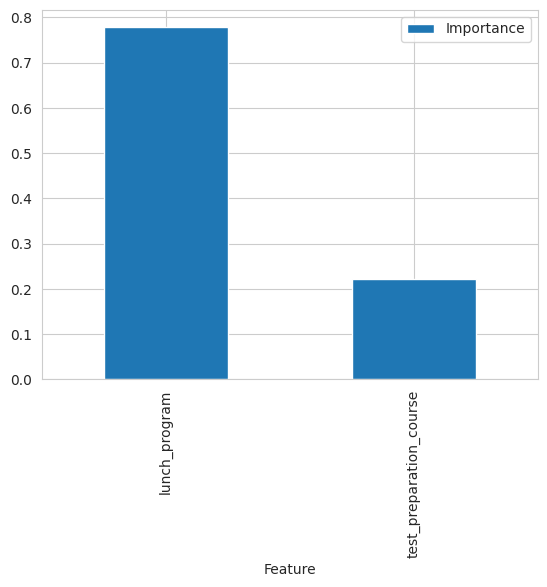

In [74]:
! rm outputs/ml_pipeline/predict_reading/v1/feature-importance-plot-reading.png

df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature-importance-plot-reading.png', bbox_inches='tight')

Excellent - we have now trained a model for predicting a student's reading score. After requiring a classification task for the math_score prediction task, we went straight for a classification method for the reading_score prediction task, reasoning that a regression model would offer poor performance.